# **Unzip the zip file**

In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/BrainTumorDS.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/BrainTumorDS.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [5]:
#count the no of images in each segregation i.e yes and no.

ROOT_DIR = "/content/Brain Tumor Data Set/Brain Tumor Data Set"
no_of_images = {}

for dir in os.listdir(ROOT_DIR):
  no_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [6]:
no_of_images.items()

dict_items([('Healthy', 2087), ('Brain Tumor', 2513)])

In [7]:
# Splitting the data in which 70 % for testing, 15 % for validation, 15 % for testing.

In [8]:
def datafolder(p, split):

  if not os.path.exists("./"+p):
    os.mkdir("./"+p)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./"+p+"/" +dir)
      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)),
                                size = (math.floor(split*no_of_images[dir])-5),
                                replace = False):
        O = os.path.join(ROOT_DIR,dir,img)
        D = os.path.join("./"+p, dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print("Folder already exist")

In [9]:
datafolder("train", 0.7)

In [10]:
datafolder("test", 0.15)

In [11]:
datafolder("val", 0.15)

# ***Building the model***

In [12]:
import keras
import tensorflow
from keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [13]:
from keras.layers.pooling.max_pooling2d import MaxPool2D
#Convolution Neural Network

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size= (3,3), activation= 'relu',input_shape = (224,224,3) ))

model.add(Conv2D(filters = 36, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units=64, activation ='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [14]:
model.compile(optimizer='adam', loss = keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# ***Data generator***

In [15]:
from keras.preprocessing.image import ImageDataGenerator
def preprocessingimages(path):
  """

  input : Path
  ouput : pre processed image
  """

  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range= 0.2,rescale = 1/255, horizontal_flip = True)

  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode= 'binary')
  return image



In [16]:
path = '/content/train'
train_data = preprocessingimages(path)

Found 3209 images belonging to 2 classes.


In [17]:
from keras.preprocessing.image import ImageDataGenerator
def preprocessingimages2(path):
  """

  input : Path
  ouput : pre processed image
  """

  image_data = ImageDataGenerator(rescale = 1/255)

  image = image_data.flow_from_directory(directory = path, target_size = (224,224), batch_size = 32, class_mode= 'binary')
  return image



In [18]:
path = '/content/test'
test_data = preprocessingimages2(path)

Found 679 images belonging to 2 classes.


In [19]:
path = '/content/val'
val_data = preprocessingimages2(path)

Found 679 images belonging to 2 classes.


# ***Early Stopping and Check point***

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience= 9, verbose= 1, mode= 'auto')

checkpoint = ModelCheckpoint(monitor = 'val_accuracy', filepath = './mymodel2.h5', verbose = 1, save_best_only= True, mode = 'auto' )

passarr = [earlystop, checkpoint]

# ***Training the model***

In [21]:
 hs = model.fit_generator(generator = train_data,
                         steps_per_epoch = 8,
                         epochs = 30,
                         verbose = 1,
                         validation_data = val_data,
                         validation_steps = 16,
                         callbacks = passarr)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.5664
Epoch 1: val_accuracy improved from -inf to 0.63086, saving model to ./mymodel2.h5
8/8 [==============================] - 18s 559ms/step - loss: 0.7581 - accuracy: 0.5664 - val_loss: 0.6499 - val_accuracy: 0.6309
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.5837
Epoch 2: val_accuracy improved from 0.63086 to 0.63477, saving model to ./mymodel2.h5
8/8 [==============================] - 5s 648ms/step - loss: 0.6643 - accuracy: 0.5837 - val_loss: 0.5986 - val_accuracy: 0.6348
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.5820
Epoch 3: val_accuracy improved from 0.63477 to 0.72656, saving model to ./mymodel2.h5
8/8 [==============================] - 4s 555ms/step - loss: 0.6777 - accuracy: 0.5820 - val_loss: 0.6058 - val_accuracy: 0.7266
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.6272 - accura

In [22]:
# Plotting our model to show the performance

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

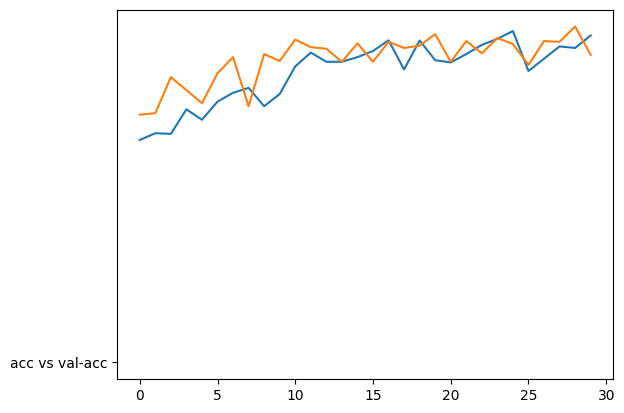

In [23]:
import matplotlib.pyplot as plt

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])

plt.plot("acc vs val-acc")
plt.show()

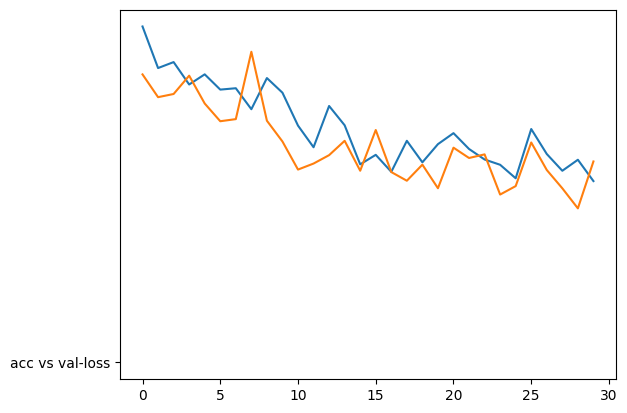

In [24]:
import matplotlib.pyplot as plt

plt.plot(h['loss'])
plt.plot(h['val_loss'])

plt.plot("acc vs val-loss")
plt.show()

In [31]:
from keras.models import load_model

model = load_model("/content/mymodel2.h5")

In [32]:
accuracy = model.evaluate_generator(test_data)[1]

print(f"the accuracy of the model is {accuracy*100}")

the accuracy of the model is 84.5360815525055


# ***Testing the model***

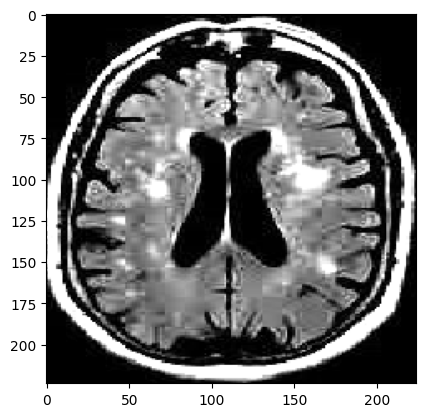

1/1 [==============================] - 0s 29ms/step
good


In [61]:
path = "/content/train/Healthy/Not Cancer  (1016).jpg"
image = load_img(path, target_size = (224,224))
input_arr = img_to_array(image)/225

plt.imshow(input_arr)
plt.show()

input_arr.shape

input_arr = np.expand_dims(input_arr, axis = 0)

pred = model.predict(input_arr)[0][0]
pred1 = (math.floor(pred * 100))
pred1

if(pred1 <= 50):
      print("bad")
else:
      print("good")


{'Brain Tumor': 0, 'Healthy': 1}